In [1]:
# importing the required libraries
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import sklearn

The Dataset is Taken from Kaggle and the link for the same is https://www.kaggle.com/chetankv/dogs-cats-images

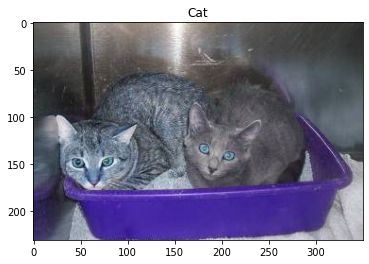

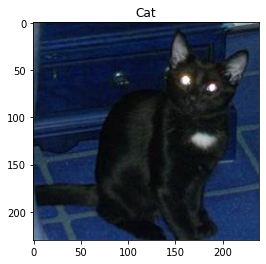

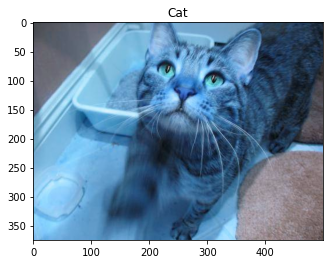

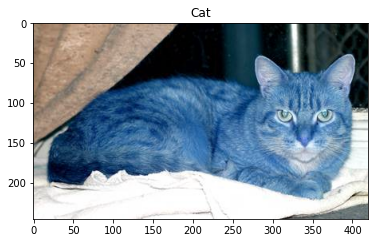

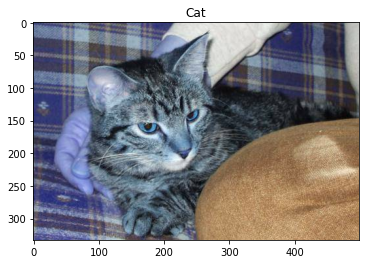

In [2]:
# let's plot 5 random cat images
import random

cat_path = './Data/training_set/cats/'

for i in range(5):
    n = random.randint(1, 4000)
    plt.figure()
    plt.title("Cat")
    plt.imshow(cv2.imread(cat_path + 'cat.' + str(n) + '.jpg', cv2.IMREAD_COLOR))

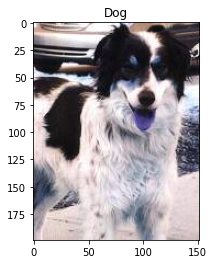

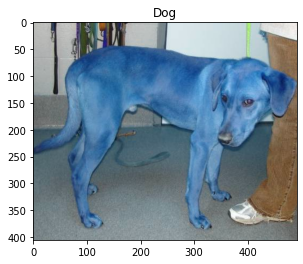

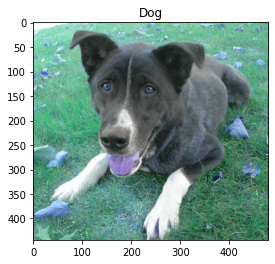

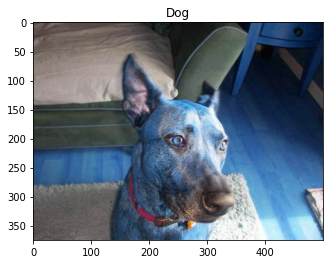

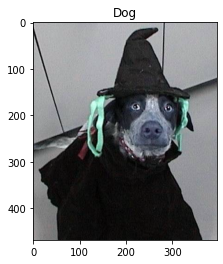

In [3]:
# let's plot 5 random dog images

dog_path = './Data/training_set/dogs/'

for i in range(5):
    n = random.randint(1, 4000)
    plt.figure()
    plt.title("Dog")
    plt.imshow(cv2.imread(dog_path + 'dog.' + str(n) + '.jpg', cv2.IMREAD_COLOR))

In [4]:
X = [] # To store images
y = [] # To store labels

# labels -
# 0 - Cat
# 1 - Dog

for entry in os.scandir(cat_path):
    img = cv2.imread(cat_path + entry.name, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (96, 96))
    img = np.array(img, dtype='float32')
    X.append(img)
    y.append(0)

In [5]:
for entry in os.scandir(dog_path):
    img = cv2.imread(dog_path + entry.name, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (96, 96))
    img = np.array(img, dtype='float32')
    X.append(img)
    y.append(1)

In [6]:
X = np.array(X)

In [7]:
X.shape # We have 8000 images in total (4000 of each)

(8000, 96, 96, 3)

In [8]:
y = np.array(y)
y.shape

(8000,)

In [9]:
# Normalization
X/=255

## Image Augmentation

Image Augmentation (creating new image samples from previous samples) is performed to increase the generalising capability of our model

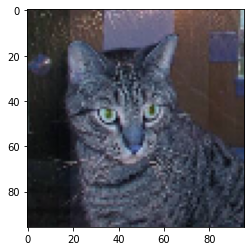

In [10]:
# Original Image
plt.imshow(X[0])

In [11]:
# randomly increasing the brightness
X_new = np.clip(random.uniform(1.5, 2)* X[0], 0.0, 1.0)

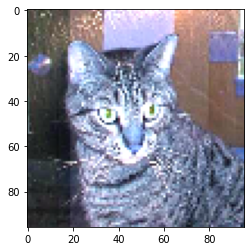

In [12]:
# Augmented Image
plt.imshow(X_new)

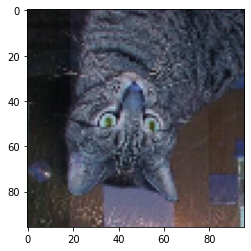

In [13]:
# rotating the images by 180 Degree
X_new = np.flip(X[0], axis = 0)
plt.imshow(X_new)

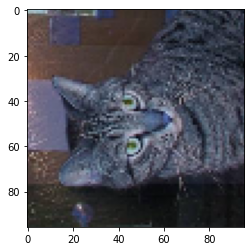

In [14]:
# rotating the images by 90 Degree
X_new = np.rot90(X[0])
plt.imshow(X_new)

We are going to perform these 3 types of image augmentation on 2000 images (1000 of each label)

In [15]:
X_aug = [] # to store augmented images
y_aug = [] # to store labels of augmented images

for i in range(3001, 5001):
    X_new = np.clip(random.uniform(1.5, 2)* X[0], 0.0, 1.0)
    X_aug.append(X_new)
    y_aug.append(y[i])
    
for i in range(2001, 3001):
    X_new = np.flip(X[i], axis = 0)
    X_aug.append(X_new)
    y_aug.append(y[i])
    
for i in range(5001, 6001):
    X_new = np.flip(X[i], axis = 0)
    X_aug.append(X_new)
    y_aug.append(y[i])
    
for i in range(1001, 2001):
    X_new = np.rot90(X[i])
    X_aug.append(X_new)
    y_aug.append(y[i])
    
for i in range(6001, 7001):
    X_new = np.rot90(X[i])
    X_aug.append(X_new)
    y_aug.append(y[i])
    
X_aug = np.array(X_aug)
y_aug = np.array(y_aug)

In [16]:
X = np.append(X, X_aug, axis=0) # appending augmented images to original list
X.shape

(14000, 96, 96, 3)

In [17]:
y = np.append(y, y_aug, axis=0)
y.shape

(14000,)

## Splitting the data

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# Taking 10% data for validation 90% for training 
# (Please note we have 2000 different images for testing)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.10, shuffle=True)

In [20]:
y_train.shape

(12600,)

In [21]:
y_val.shape

(1400,)

## Creating and Training the Model

In [22]:
model = keras.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(2,2), activation='relu', input_shape=(96, 96, 3)),
    keras.layers.MaxPooling2D((2,2)),
    
    keras.layers.ZeroPadding2D(padding=(1, 1)),
    keras.layers.Conv2D(filters=192, kernel_size=(3,3), activation='relu', padding='valid'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(filters=384, kernel_size=(4,4), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(filters=384, kernel_size=(4,4), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    
    keras.layers.Flatten(),
    keras.layers.Dense(96, activation='relu'),
    keras.layers.Dense(192, activation='relu'),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 95, 95, 96)        1248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 47, 47, 96)        0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 49, 49, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 192)       166080    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 192)       0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 192)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 384)       1

In [24]:
# compile the model
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [25]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)

# save the best model with lower validation loss
checkpointer = keras.callbacks.ModelCheckpoint(filepath = "DogvsCat_weights.hdf5", verbose = 1, save_best_only=True)

In [26]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[checkpointer, earlystopping])

Epoch 1/100
394/394 [==============================] - ETA: 0s - loss: 0.6945 - accuracy: 0.5175
Epoch 00001: val_loss improved from inf to 0.69069, saving model to DogvsCat_weights.hdf5
394/394 [==============================] - 33s 83ms/step - loss: 0.6945 - accuracy: 0.5175 - val_loss: 0.6907 - val_accuracy: 0.5264
Epoch 2/100
394/394 [==============================] - ETA: 0s - loss: 0.6910 - accuracy: 0.5256
Epoch 00002: val_loss improved from 0.69069 to 0.68993, saving model to DogvsCat_weights.hdf5
394/394 [==============================] - 33s 83ms/step - loss: 0.6910 - accuracy: 0.5256 - val_loss: 0.6899 - val_accuracy: 0.5264
Epoch 3/100
394/394 [==============================] - ETA: 0s - loss: 0.6898 - accuracy: 0.5256
Epoch 00003: val_loss improved from 0.68993 to 0.68317, saving model to DogvsCat_weights.hdf5
394/394 [==============================] - 32s 82ms/step - loss: 0.6898 - accuracy: 0.5256 - val_loss: 0.6832 - val_accuracy: 0.5471
Epoch 4/100
394/394 [===========

In [27]:
# saving the model architecture to json file for future use

model_json = model.to_json()
with open("DogvsCat-model.json","w") as json_file:
  json_file.write(model_json)

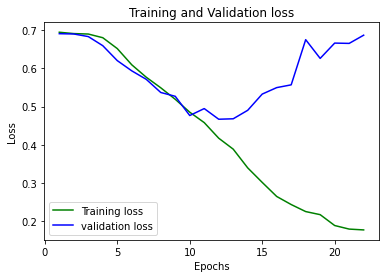

In [28]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,23)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

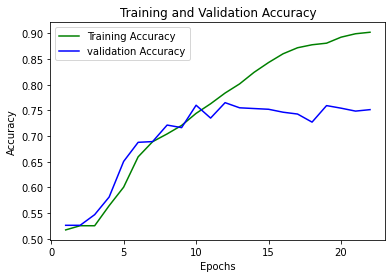

In [29]:
accuracy_train = history.history['accuracy']
accuracy_val = history.history['val_accuracy']
epochs = range(1,23)
plt.plot(epochs, accuracy_train, 'g', label='Training Accuracy')
plt.plot(epochs, accuracy_val, 'b', label='validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Testing the Best Trained Model

In [35]:
with open('DogvsCat-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model architecture 
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('DogvsCat_weights.hdf5')
model.compile(optimizer = "Adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [36]:
X = [] # To store images
y = [] # To store labels

# labels -
# 0 - Cat
# 1 - Dog

cat_path = './Data/test_set/cats/'
dog_path = './Data/test_set/dogs/'

for entry in os.scandir(cat_path):
    img = cv2.imread(cat_path + entry.name, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (96, 96))
    img = np.array(img, dtype='float32')
    X.append(img)
    y.append(0)
    
for entry in os.scandir(dog_path):
    img = cv2.imread(dog_path + entry.name, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (96, 96))
    img = np.array(img, dtype='float32')
    X.append(img)
    y.append(1)
    
X_test = np.array(X)
X_test/=255
y_true = np.array(y)

In [37]:
predictions = model.predict(X_test)

In [38]:
predicted = []

for i in predictions:
    predicted.append(np.argmax(i))

In [39]:
from sklearn.metrics import classification_report

print(classification_report(y_true, predicted))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1000
           1       0.81      0.82      0.82      1000

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



<AxesSubplot:>

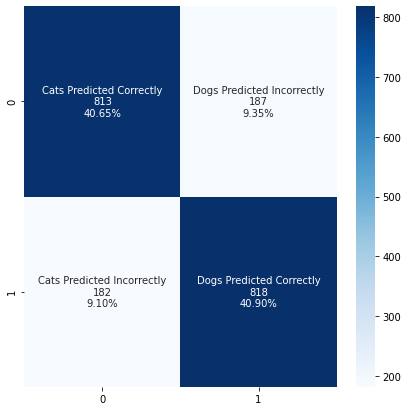

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_true, predicted)
plt.figure(figsize = (7,7))

group_names = ['Cats Predicted Correctly','Dogs Predicted Incorrectly','Cats Predicted Incorrectly','Dogs Predicted Correctly']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')